# Textual Document Classification using BERT

Document classification is a common task in document processing. The following steps are required for building a model to classify the textual document.

- Loading Data
- Text Extraction from images
- Data Preprocessing
- Model Training
- Model Evaluation
- Model Serving

### Installing & Loading all the dependencies

In [1]:
!pip install -qU transformers torch Pillow pytesseract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.2 MB/s eta 0:00:00


In [2]:
import os
from PIL import Image

# Step 1: Loading Data

In [65]:
from google.colab import drive
drive.mount('/content/drive')
data_directory = "/content/drive/MyDrive/data"

# data_directory = "/kaggle/input/document-classification-dataset"

# !sudo apt install tree
!tree -L 1 $data_directory -f

/content/drive/MyDrive/data
├── /content/drive/MyDrive/data/email
├── /content/drive/MyDrive/data/resume
└── /content/drive/MyDrive/data/scientific_publication

3 directories, 0 files


In [66]:
!ls $data_directory/email | wc -l
!ls $data_directory/resume | wc -l
!ls $data_directory/scientific_publication | wc -l

55
55
55


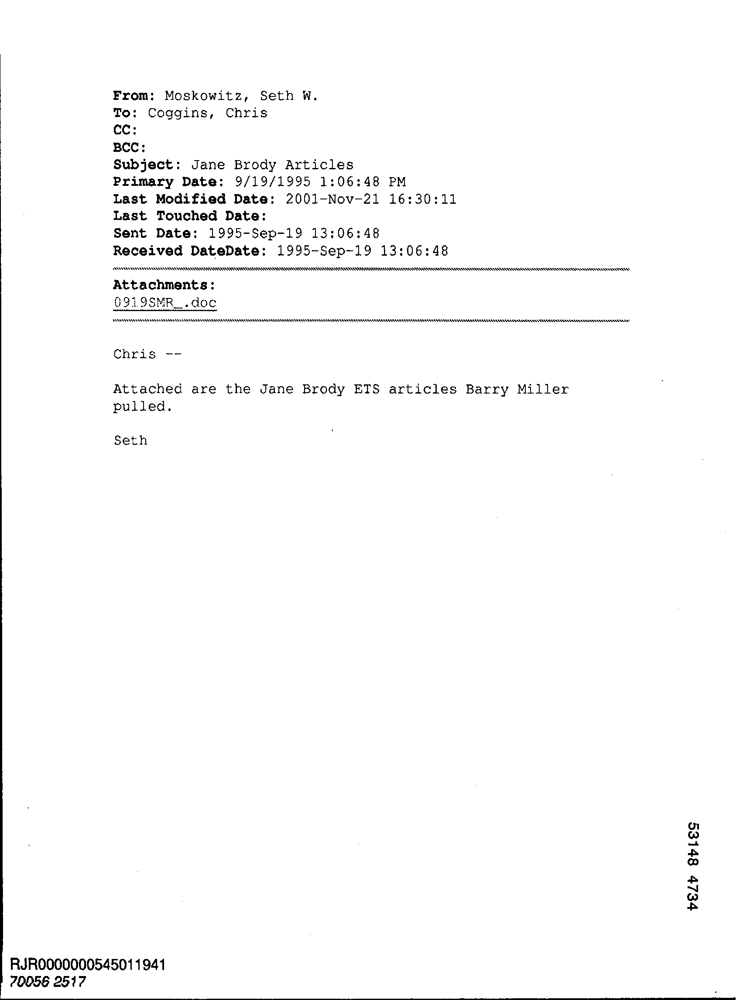

In [6]:
img = Image.open(os.path.join(data_directory, "email/doc_000042.png"))
img

In [67]:
!sudo apt install tesseract-ocr
!pip -q install pytesseract

import pytesseract

print(pytesseract.image_to_string(img))

 

From: Moskowitz, Seth W.

To: Coggins, Chris

ce:

BC

Subject: Jane Brody Articles

Primary Date: 9/19/1995 1:06:48 PM

Last Modified Date: 2001-Nov-21 16:30:11

Last Touched Date

Sent Date: 1995-Sep-19 13:06:48

Received DateDate: 1995-Sep-19 13:06:48

Attachments:
9SMR_.doc

 

 

 

 

 

Chris --

Attached are the Jane Brody BTS articles Barry Miller
pulled.

seth

RJRO000000545011941

70056 2517

veLb Bbles

 



In [8]:
class_folders = os.listdir(data_directory)
class_to_label = {class_folder: index for index, class_folder in enumerate(class_folders)}

images = []
labels = []

for class_folder in class_folders:
    class_path = os.path.join(data_directory, class_folder)
    for image_filename in os.listdir(class_path):
        image_path = os.path.join(class_path, image_filename)
        # Open the image and convert it to grayscale if needed
        image = Image.open(image_path).convert("L")  # "L" mode converts to grayscale
        images.append(image)
        labels.append(class_to_label[class_folder])

d = {label: labels.count(label) for label in labels}
d

{0: 55, 1: 55, 2: 55}

# Step 2: Text Extraction from Images

In [10]:
# Function to extract text from images using Tesseract OCR
def extract_text_from_images(images):
    extracted_texts = []
    for image in images:
        extracted_text = pytesseract.image_to_string(image)
        extracted_texts.append(extracted_text)
    return extracted_texts

In [11]:
%timeit extract_text_from_images([images[0]])

15.5 s ± 1.12 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
extracted_texts = extract_text_from_images(images)
# extracted_texts = [extracted_texts[idx].replace("\n", ' ') for idx, value in enumerate(extracted_texts)]

# Step 3: Data Preprocessing

Steps for Data Preprocessing

1. **Replace Newline Characters with Whitespace**:
   - Replace all occurrences of `'\n'` with whitespace in the extracted text.

2. **Lowercasing**:
    - Convert all text to lowercase.

3. **Fix Contractions**:
    - Expand contractions using the contractions library.
    - ```python
        import contractions

        # Example input text with contractions
        text_with_contractions = "I can't believe it's raining today. I won't go out in this weather."

        # Fix contractions in the input text
        expanded_text = contractions.fix(text_with_contractions)

        # Output the expanded text
        print(expanded_text)

        expanded_text = 'I cannot believe it is raining today. I will not go out in this weather.'
    ```

4. **Remove Numbers**:
    - Remove all numeric digits.
    - ```python
        import re

        # Example input text with numbers
        text_with_numbers = "I have 3 apples and 2 oranges in my bag."

        # Remove numbers from the input text
        text_without_numbers = re.sub(r'\d+', '', text_with_numbers)

        # Output the text without numbers
        print(text_without_numbers)

        text_without_numbers = 'I have  apples and  oranges in my bag.'
    ```

5. **Remove Punctuation**:
    - Remove all punctuation marks.
    - ```python
        text = "Hello! This is an example, text with some punctuation marks!!!"
        cleaned_text = "Hello This is an example text with some punctuation marks"
    ```

6. **Tokenization**:
    - Split the text into individual words (tokens).

7. **Remove Stopwords**:
    - Remove common English stopwords.

8. **Spelling Correction**:
    - Correct spelling mistakes using the pyspellchecker library.
    ```python
        tokens = ["writting", "dictionery", "spellinng", "correctt"]
        
        spell = SpellChecker()
        corrected_tokens = [spell.correction(word) for word in tokens]
        
        print(corrected_tokens)

        corrected_tokens = ['writing', 'dictionary', 'spelling', 'correct']
    ```

9. **Part-of-Speech Tagging and Lemmatization**:
    - Assign parts of speech to words and lemmatize them to their base form.

    - ```python
        pos_tags = pos_tag(corrected_tokens)
        pos_tags = [('writting', 'VBG'),
                    ('dictionary', 'JJ'),
                    ('spelling', 'NN'),
                    ('correct', 'NN')]
        ```
    - Benefits of Using POS Tags in Lemmatization
        - Accurate Lemmatization
        - Contextual Lemmatization
        - Improved Text Understanding

10. **Rejoin Tokens**:
    - Rejoin the preprocessed tokens into text.

In [15]:
!pip install -qU contractions pyspellchecker

In [19]:
!pip install pyspellchecker --force-reinstall

  Using cached pyspellchecker-0.7.2-py3-none-any.whl (3.4 MB)
  Attempting uninstall: pyspellchecker
    Found existing installation: pyspellchecker 0.7.2
    Uninstalling pyspellchecker-0.7.2:
      Successfully uninstalled pyspellchecker-0.7.2


In [20]:
import re
import string
import contractions
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [21]:
'''
The pos_tag function returns Part-of-Speech tags in the form of Penn Treebank POS tags,
but the WordNetLemmatizer in NLTK expects WordNet POS tags and then perform lemmatization
'''
# Map Penn Treebank POS tags to WordNet POS tags for lemmatization
def penn_to_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun if POS tag is unknown

def preprocess_text(text):
    if text is None or not text.strip():
        print("Empty Text found")
        return ""

    # Replace '\n' with whitespace
    text = text.replace('\n', ' ')

    # Lowercasing
    text = text.lower()

    # Fix contractions
    text = contractions.fix(text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Spelling correction
    spell = SpellChecker()
    corrected_tokens = [spell.correction(word) for word in tokens]
    # print(corrected_tokens)
    corrected_tokens = [word for word in corrected_tokens if word is not None]
    # print(corrected_tokens)


    # Part-of-Speech Tagging and Lemmatization
    pos_tags = pos_tag(corrected_tokens)
    lemmatizer = WordNetLemmatizer()

    # tokens = []
    # for word,pos in pos_tags:
    #     try:
    #         print(lemmatizer.lemmatize(word, pos=pos))
    #         tokens.append(lemmatizer.lemmatize(word, pos=pos))
    #     except:
    #         print("Exception",word, pos)
    # tokens = [lemmatizer.lemmatize(word, pos=pos) for word, pos in pos_tags]
    tokens = [lemmatizer.lemmatize(word, pos=penn_to_wordnet_pos(pos_tag)) for word, pos_tag in pos_tags]
    # print(tokens)


    # Rejoin tokens into text
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [22]:
%timeit preprocess_text(extracted_texts[0])

29.7 s ± 668 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
!ls $data_directory

email  resume  scientific_publication


In [27]:
!pwd

/content


In [34]:
base_dir =  '/content/drive/MyDrive/'

preprocessed_texts = []
counter = 1

# Open a text file in write mode
with open(os.path.join(base_dir, "preprocessed_text.txt"), "w") as file:
    for idx,text in enumerate(extracted_texts):
        preprocessed_text = preprocess_text(text)

        preprocessed_texts.append(preprocessed_text)

        file.write(f"{idx}: {preprocessed_text}\n")

        if counter % 10 == 0:
            print(f"Number of files processed: {counter}")

        counter += 1

In [36]:
len(preprocessed_texts)

165

In [38]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch

# Preprocess the extracted texts
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts = tokenizer(preprocessed_texts, padding=True, truncation=True, return_tensors='pt')

tokenized_texts.input_ids.shape, tokenized_texts.attention_mask.shape

(torch.Size([165, 512]), torch.Size([165, 512]))

# Step 4: Data Splitting

In [40]:
# Split data into training and validation sets
input_ids = tokenized_texts.input_ids
attention_mask = tokenized_texts.attention_mask
labels = torch.tensor(labels)

print("Input ids Shape:",input_ids.shape)
print("attention_mask Shape:",attention_mask.shape)
print("labels Shape:",labels.shape)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.2)
train_masks, val_masks, _, _ = train_test_split(attention_mask, input_ids, random_state=42, test_size=0.2)

print()

print("Train Input ids Shape:",train_inputs.shape)
print("Train attention_mask Shape:",train_masks.shape)
print("Train labels Shape:",train_labels.shape)

print()

print("Test Input ids Shape:",val_inputs.shape)
print("Test attention_mask Shape:",val_masks.shape)
print("Test labels Shape:",val_labels.shape)

print()

print("Train Sample Count[Class-wise]", {label: list(train_labels.numpy()).count(label) for label in list(train_labels.numpy())})
print("Test Sample Count[Class-wise]", {label: list(val_labels.numpy()).count(label) for label in list(val_labels.numpy())})

Input ids Shape: torch.Size([165, 512])
attention_mask Shape: torch.Size([165, 512])
labels Shape: torch.Size([165])

Train Input ids Shape: torch.Size([132, 512])
Train attention_mask Shape: torch.Size([132, 512])
Train labels Shape: torch.Size([132])

Test Input ids Shape: torch.Size([33, 512])
Test attention_mask Shape: torch.Size([33, 512])
Test labels Shape: torch.Size([33])

Train Sample Count[Class-wise] {1: 44, 0: 44, 2: 44}
Test Sample Count[Class-wise] {2: 11, 1: 11, 0: 11}


In [41]:
# Create custom dataset and dataloaders
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

train_dataset = CustomDataset(train_inputs, train_masks, train_labels)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = CustomDataset(val_inputs, val_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Step 5: Model Training

In [42]:
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np


# Initialize and train BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyperparameters
epochs = 10
learning_rates = [1e-5, 5e-5, 1e-4]
optimizers = ['AdamW', 'Adam']
best_val_loss = np.inf
best_model_path = None
model_dir = '/content/drive/MyDrive/bert_models/'

for lr in learning_rates:
    for optimizer_name in optimizers:
        optimizer = None
        if optimizer_name == 'AdamW':
            optimizer = AdamW(model.parameters(), lr=lr)
        elif optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        else:
            raise ValueError("Unsupported optimizer!")

        early_stopping_counter = 0
        for epoch in range(epochs):
            model.train()
            for batch in train_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                    val_loss += outputs.loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f'Epoch {epoch + 1}/{epochs}, LR: {lr}, Optimizer: {optimizer_name}, Loss: {avg_val_loss}')

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_path = model_dir + f'bert_document_classification_model_lr{lr}_{optimizer_name}.pt'
                torch.save(model.state_dict(), best_model_path)
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= 3:
                    print("Early stopping triggered!")
                    break

print(f"Best model saved at: {best_model_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, LR: 1e-05, Optimizer: AdamW, Loss: 0.8635941876305474
Epoch 2/10, LR: 1e-05, Optimizer: AdamW, Loss: 0.6372795038753085
Epoch 3/10, LR: 1e-05, Optimizer: AdamW, Loss: 0.4005866116947598
Epoch 4/10, LR: 1e-05, Optimizer: AdamW, Loss: 0.33868399759133655
Epoch 5/10, LR: 1e-05, Optimizer: AdamW, Loss: 0.305625947813193
Epoch 6/10, LR: 1e-05, Optimizer: AdamW, Loss: 0.2573680794901318
Epoch 7/10, LR: 1e-05, Optimizer: AdamW, Loss: 0.24401847107542884
Epoch 8/10, LR: 1e-05, Optimizer: AdamW, Loss: 0.2701251320540905
Epoch 9/10, LR: 1e-05, Optimizer: AdamW, Loss: 0.26844918148385155
Epoch 10/10, LR: 1e-05, Optimizer: AdamW, Loss: 0.2712675318535831
Early stopping triggered!
Epoch 1/10, LR: 1e-05, Optimizer: Adam, Loss: 0.42627443709514207
Epoch 2/10, LR: 1e-05, Optimizer: Adam, Loss: 0.4786955657829013
Epoch 3/10, LR: 1e-05, Optimizer: Adam, Loss: 0.29219401348382235
Early stopping triggered!


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, LR: 5e-05, Optimizer: AdamW, Loss: 0.24770922288330943
Epoch 2/10, LR: 5e-05, Optimizer: AdamW, Loss: 0.7051430228036932
Epoch 3/10, LR: 5e-05, Optimizer: AdamW, Loss: 0.34848050423897803
Early stopping triggered!
Epoch 1/10, LR: 5e-05, Optimizer: Adam, Loss: 0.3732119297512529
Epoch 2/10, LR: 5e-05, Optimizer: Adam, Loss: 0.1281997612580502
Epoch 3/10, LR: 5e-05, Optimizer: Adam, Loss: 0.3033772373908303
Epoch 4/10, LR: 5e-05, Optimizer: Adam, Loss: 0.17372861311277019
Epoch 5/10, LR: 5e-05, Optimizer: Adam, Loss: 0.33471514460527235
Early stopping triggered!
Epoch 1/10, LR: 0.0001, Optimizer: AdamW, Loss: 0.2519204074144202
Epoch 2/10, LR: 0.0001, Optimizer: AdamW, Loss: 0.5741923194792535
Epoch 3/10, LR: 0.0001, Optimizer: AdamW, Loss: 0.37484503894423443
Early stopping triggered!
Epoch 1/10, LR: 0.0001, Optimizer: Adam, Loss: 1.0440072872572475
Epoch 2/10, LR: 0.0001, Optimizer: Adam, Loss: 0.6790991241319312
Epoch 3/10, LR: 0.0001, Optimizer: Adam, Loss: 0.697174261847

# Step 6: Model Evaluation

1. **Accuracy**:
    - Proportion of correct prediction
2. **Confusion Matrix**:
    - A confusion matrix provides a detailed breakdown of correct and incorrect predictions, allowing you to calculate metrics like precision, recall, and F1-score.
3. **Classification Report**:
    - A classification report provides precision, recall, F1-score, and support for each class.


In [60]:
# Accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Put the model in evaluation mode
model.eval()

# Initialize variables to calculate accuracy
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        # Update accuracy metrics
        total_correct += torch.sum(predictions == labels).item()
        total_samples += len(labels)

# Calculate accuracy
accuracy = total_correct / total_samples
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.97


In [61]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report

# Get predictions and true labels for the entire validation dataset
all_predictions = []
all_true_labels = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        # Update lists for confusion matrix
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
confusion = confusion_matrix(all_true_labels, all_predictions)
print("Confusion Matrix:")
print(confusion)


Confusion Matrix:
[[10  0  1]
 [ 0 11  0]
 [ 0  0 11]]


In [63]:
# Calculate classification report

class_names = class_to_label.keys()  #['class_1', 'class_2', 'class_3']
report = classification_report(all_true_labels, all_predictions, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
                        precision    recall  f1-score   support

scientific_publication       1.00      0.91      0.95        11
                 email       1.00      1.00      1.00        11
                resume       0.92      1.00      0.96        11

              accuracy                           0.97        33
             macro avg       0.97      0.97      0.97        33
          weighted avg       0.97      0.97      0.97        33



# Step 7: Model Serving

In [56]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the model from the local file path
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(torch.load(best_model_path))

# Set the model in evaluation mode
model.eval()

# Load the tokenizer from 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to predict document class
def predict_document_class(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


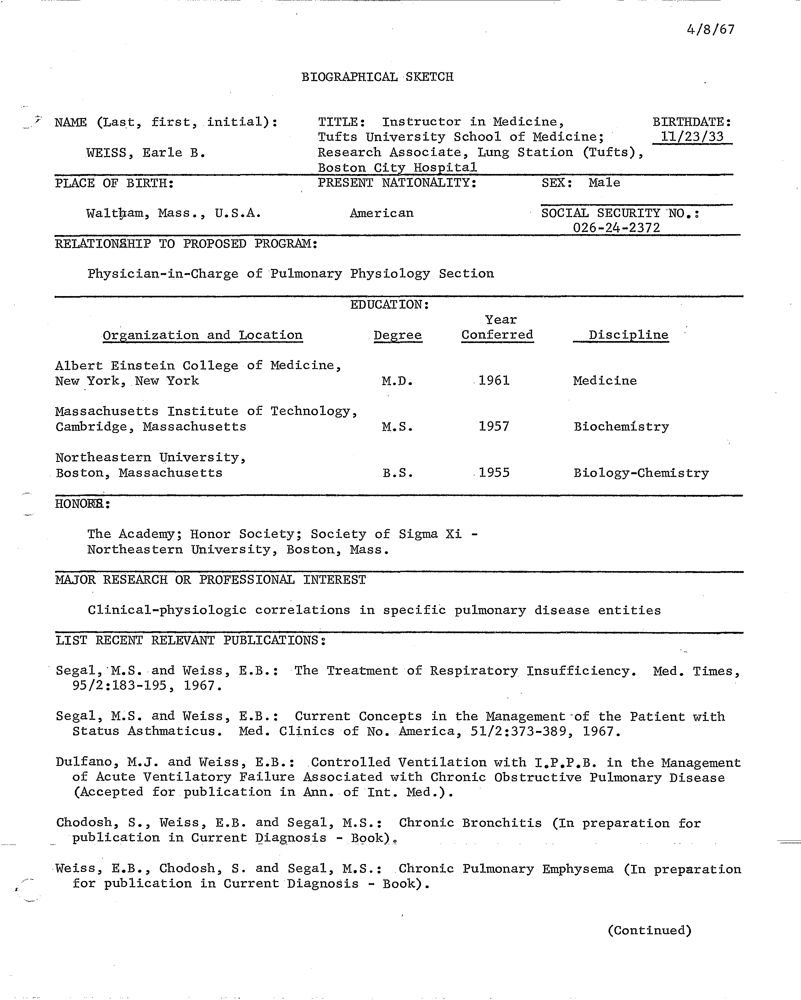

In [57]:
images[-1]

In [58]:
# Example usage
document_text = extract_text_from_images([images[-1]])
predicted_class = predict_document_class(document_text)
print(f'Predicted Class: {predicted_class}')


Predicted Class: 2


In [59]:
class_to_label

{'scientific_publication': 0, 'email': 1, 'resume': 2}

### Challenges & Remedies

1. **Computational**:
    - Training a BERT model trains well if we have a dedicated GPU.
        - **Remedy**: Utilized the GPU in Google Colab
    - Preprocessing text of a single document require at least 30 seconds making it infeasible working with 1000s of document
        - **Remedy**: Run the preprocessing task at More Core processor and save the processed text as a .txt file.
2. **OCR Engine Performance**:
    - Input to the model is the text which is extracted using OCR Engine. The more accurate the OCR Engine is, the better the model fine-tuning will be.
        - **Remedy**: Premium OCR Engine like Google Vision OCR performs well and give the result faster as compare to Tesseract OCR Engine which is used in this project.

3. **Data Quality & Quantity**:
    - BERT models require large amounts of data for effective training, and obtaining a substantial, well-labeled dataset can be challenging, especially for specific domains.
        - **Remedy**:
            - **Data Augmentation**: Apply techniques such as synonym replacement to artificially increase the size of your dataset.
            - **Domain-Specific Pretraining**: Consider using domain-specific pretrained BERT models.
4. **Training Challenges**:
    - Training large transformer models like BERT can be time-consuming, especially if the dataset is vast and the model architecture is complex.
        - **Remedy**:
            - **Gradient Accumulation**: simulate training with larger batch sizes without increasing GPU memory requirements significantly.
5. **Fine-Tuning Challenges**:
    - Finding the optimal learning rate, batch size, and number of epochs for fine-tuning BERT can be challenging and time-consuming.
        - **Remedy**: Hyperparameter Tuning with multiple values & Early Stopping.
6. **Label Imbalance**:
    - classes might not be balanced, leading to biased models.
        - **Remedy**: Assign higher weights to minority classes during loss calculation to penalize misclassifications of minority classes more.